In [8]:
import pandas as pd
import numpy as np

from modeling.ensemble_models import ForestRegressions, XGBoostRegressions, ExtraTreesRegressions
from modeling.plots import plot_data, plot_daily_data

In [9]:
SolarData22 = pd.read_csv('../data/Processed/Solar2022.csv',index_col=0,parse_dates=[0])
SolarData23 = pd.read_csv('../data/Processed/Solar2023.csv',index_col=0,parse_dates=[0])
SolarData24 = pd.read_csv('../data/Processed/Solar2024.csv',index_col=0,parse_dates=[0])

In [10]:
#Add energy lag columns so forests can partially involve time
SolarData22Lags = SolarData22.copy()
SolarData23Lags = SolarData23.copy()
SolarData24Lags = SolarData24.copy()
for lag in [1,2,3,6,24]:
    SolarData22Lags[f'Energy Lag {lag}'] = SolarData22Lags['Energy'].shift(lag)
    SolarData23Lags[f'Energy Lag {lag}'] = SolarData23Lags['Energy'].shift(lag)
    SolarData24Lags[f'Energy Lag {lag}'] = SolarData24Lags['Energy'].shift(lag)
SolarData22Lags.dropna(inplace=True)
SolarData23Lags.dropna(inplace=True)
SolarData24Lags.dropna(inplace=True)

In [11]:
#Restrict to when sun ~above horizon
SolarDataDay22 = SolarData22Lags[SolarData22Lags['Solar Zenith Angle']<np.pi/2]
SolarDataDay23 = SolarData23Lags[SolarData23Lags['Solar Zenith Angle']<np.pi/2]
SolarDataDay24 = SolarData24Lags[SolarData24Lags['Solar Zenith Angle']<np.pi/2]

In [12]:
SolarTrain = pd.concat([SolarDataDay22,SolarDataDay23])
SolarTest = SolarDataDay24.copy()

In [13]:
RandomForestModels = ForestRegressions(SolarTrain,SolarTest)

In [16]:
features = ['Solar Zenith Angle']
RandomForestModels.fit(features)

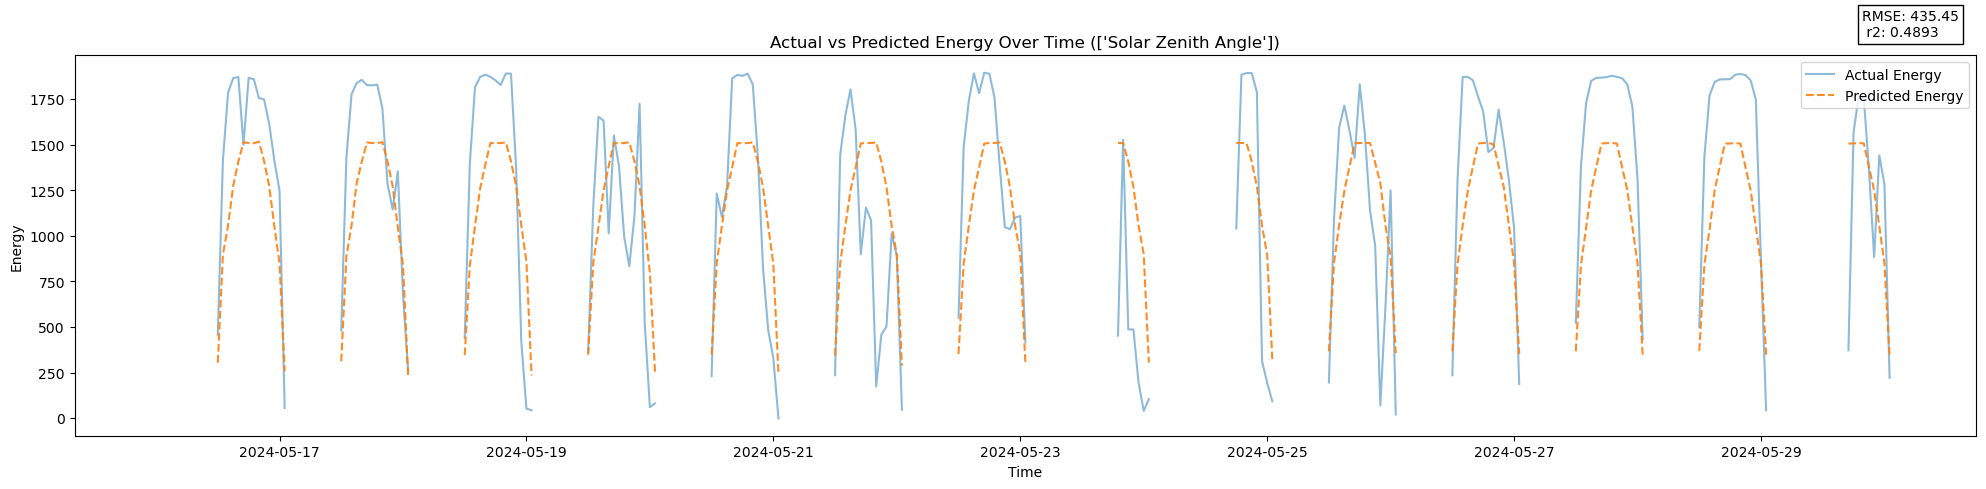

In [17]:
plot_data(features,RandomForestModels.predictions(features))

In [14]:
features = ['Solar Zenith Angle','Relative Humidity','tcc']
RandomForestModels.fit(features)

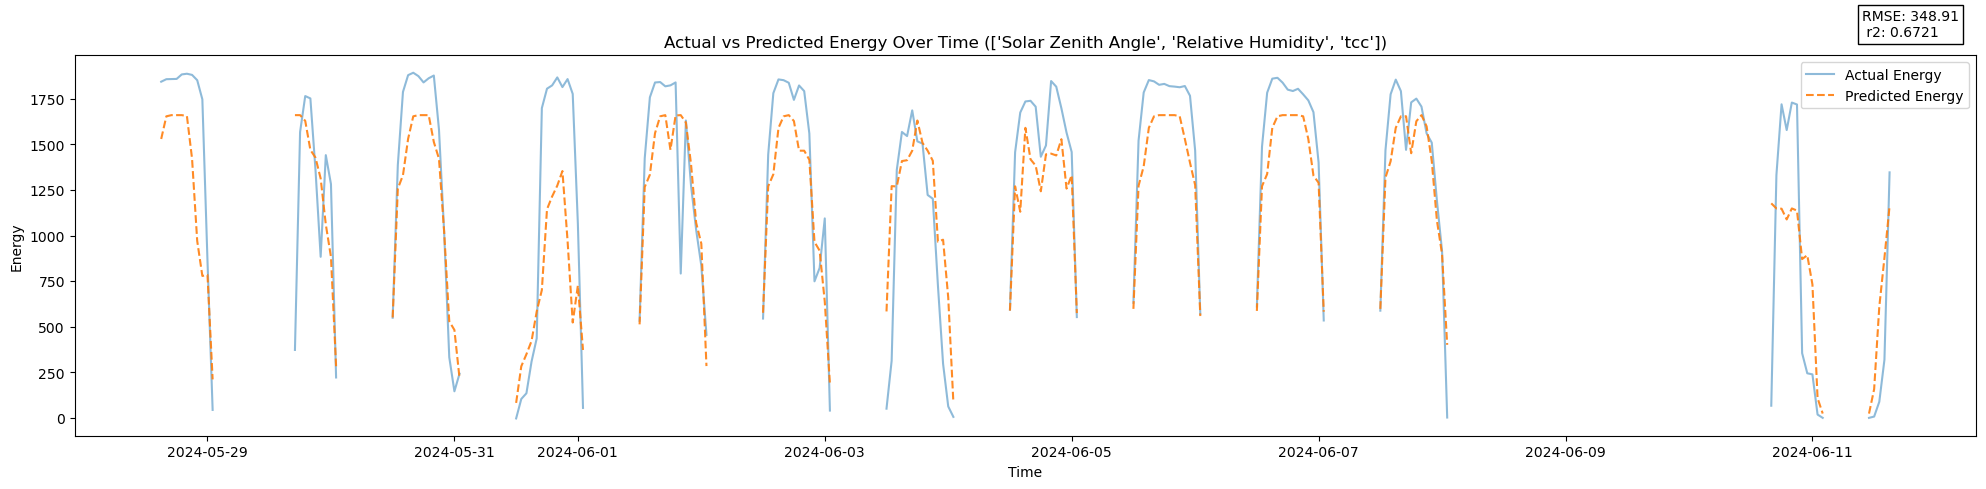

In [15]:
plot_data(features,RandomForestModels.predictions(features))

In [13]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6']
RandomForestModels.fit(features)

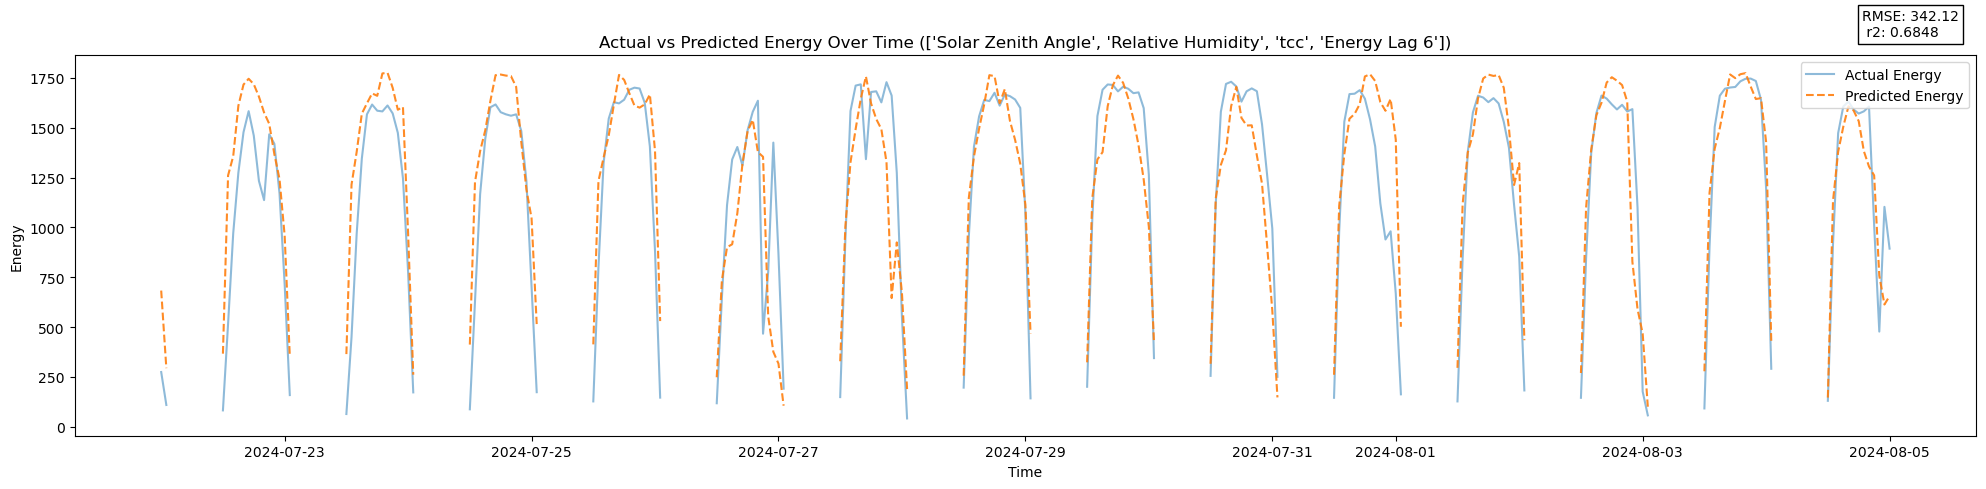

In [14]:
plot_data(features,RandomForestModels.predictions(features))

In [15]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 6','Energy Lag 24']
RandomForestModels.fit(features)

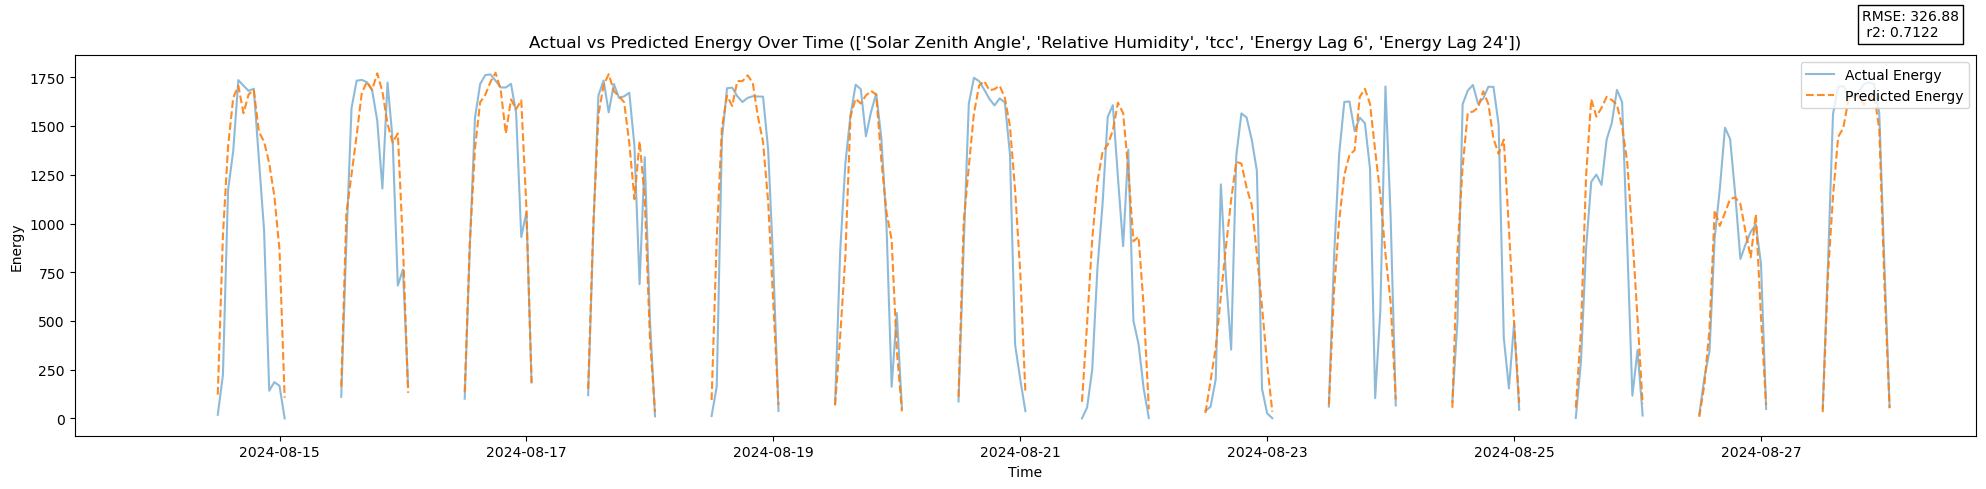

In [16]:
plot_data(features,RandomForestModels.predictions(features))

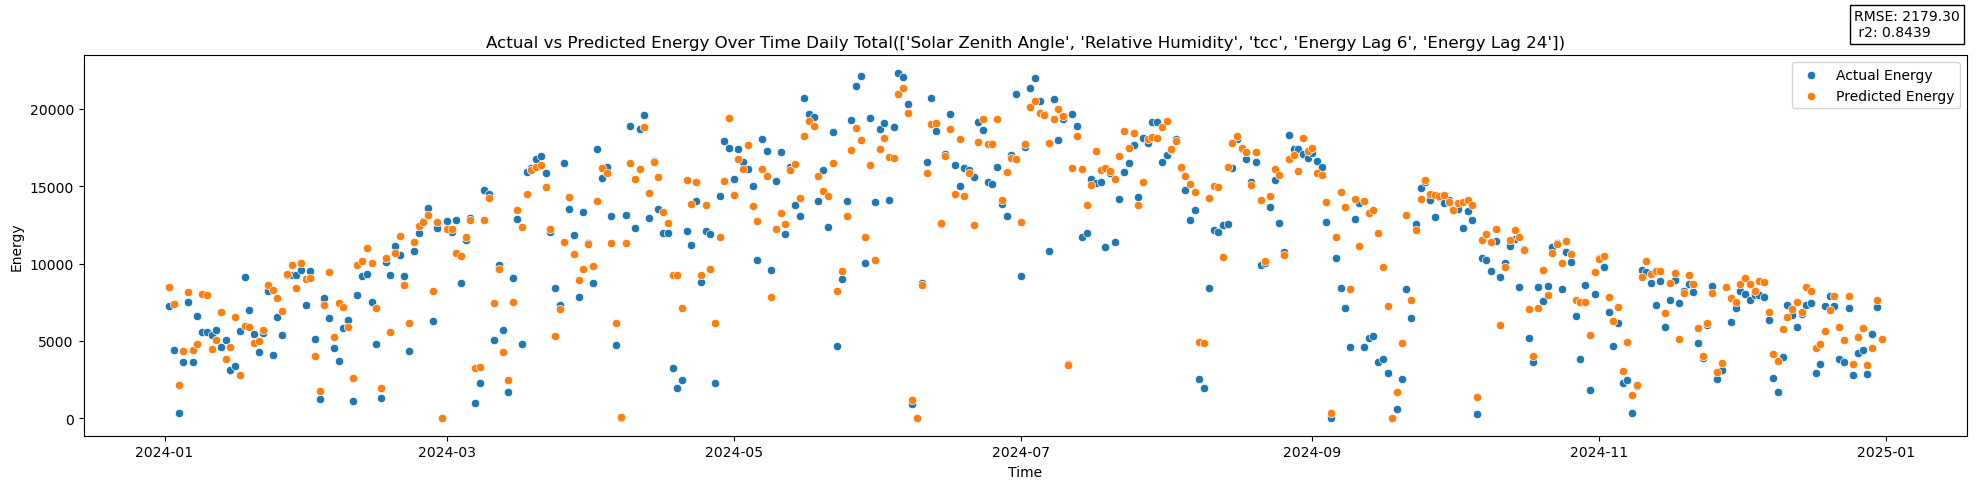

In [51]:
plot_daily_data(features,RandomForestModels.predictions(features))

In [17]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']
RandomForestModels.fit(features)

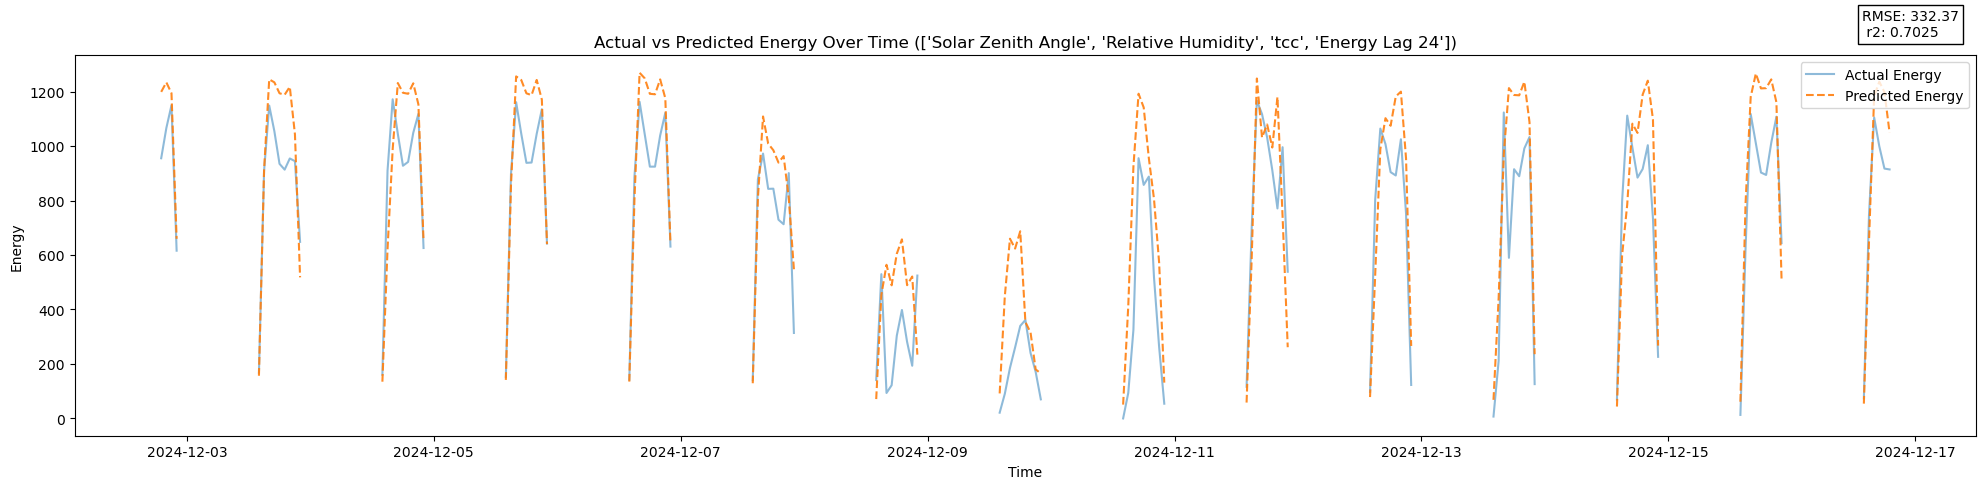

In [18]:
plot_data(features,RandomForestModels.predictions(features))

In [20]:
ExtraTreeModels = ExtraTreesRegressions(SolarTrain,SolarTest)

In [22]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']
ExtraTreeModels.fit(features)

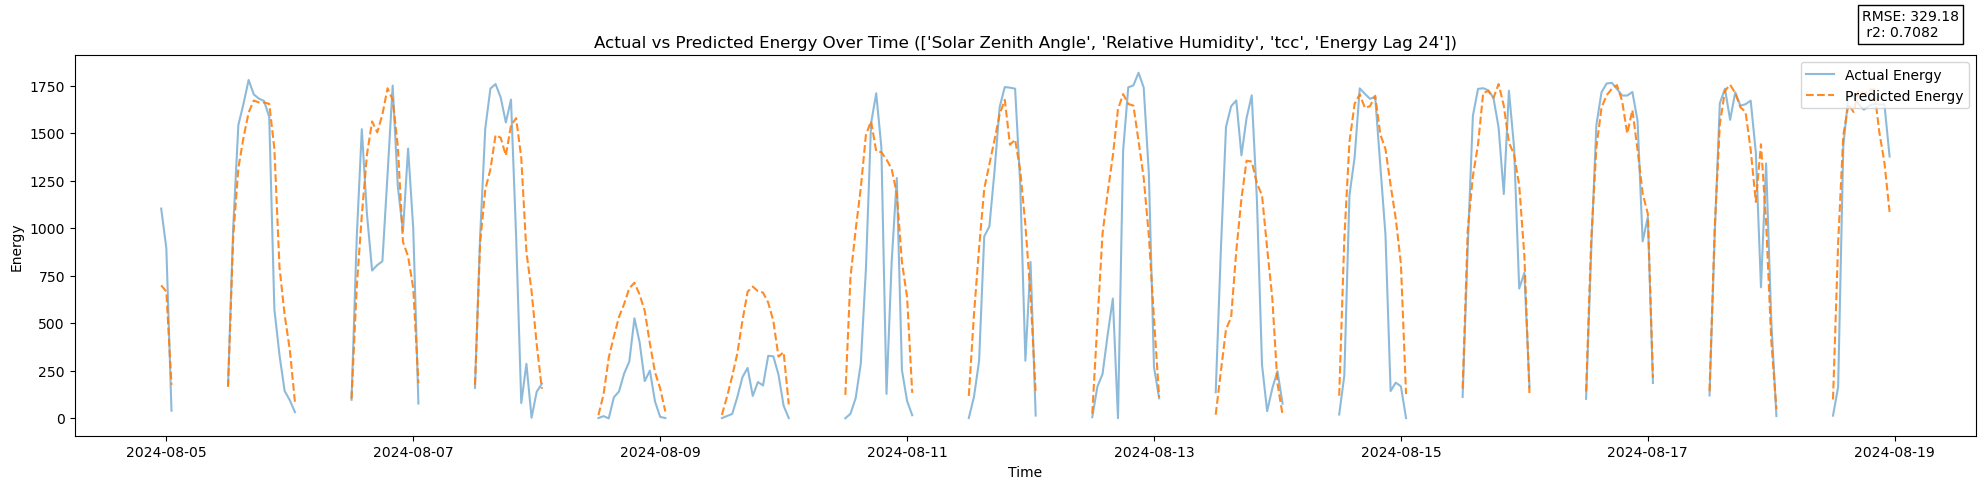

In [23]:
plot_data(features,ExtraTreeModels.predictions(features))

In [24]:
features = ['Solar Zenith Angle','Relative Humidity','tcc']
ExtraTreeModels.fit(features)

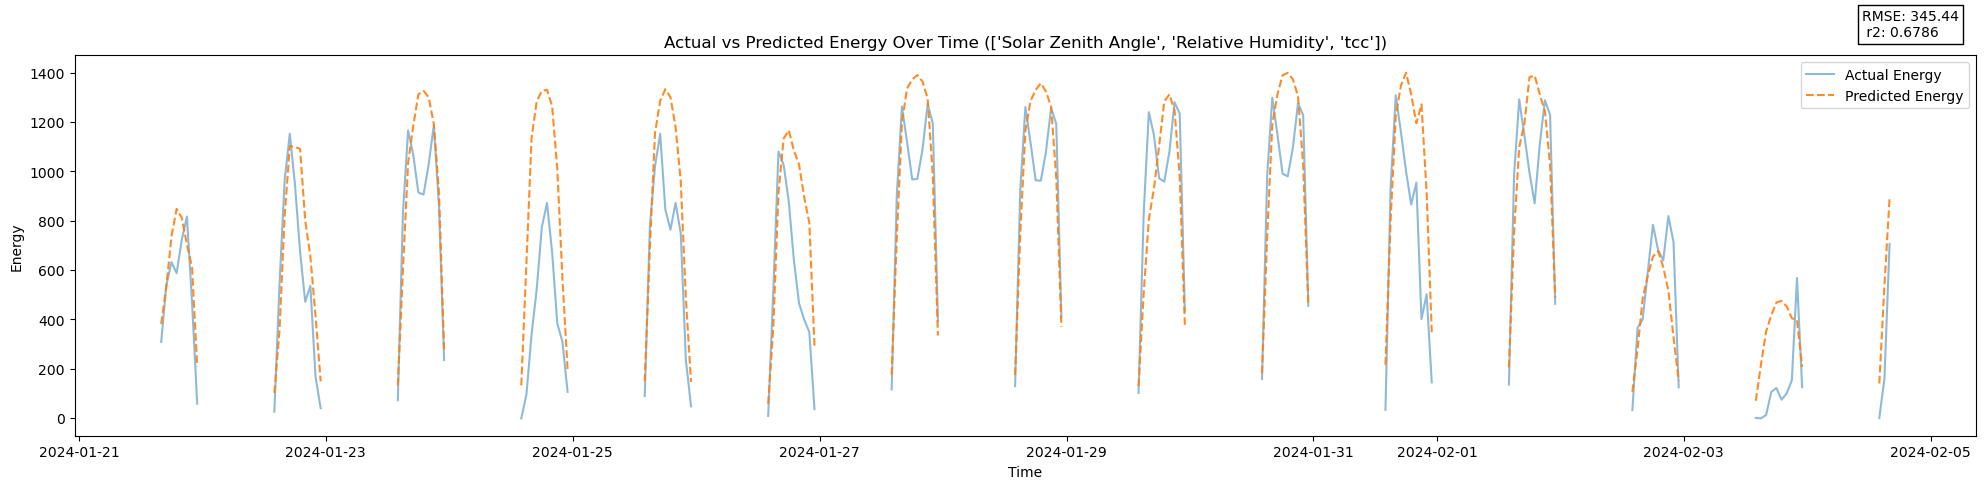

In [25]:
plot_data(features,ExtraTreeModels.predictions(features))

In [26]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 3']
ExtraTreeModels.fit(features)

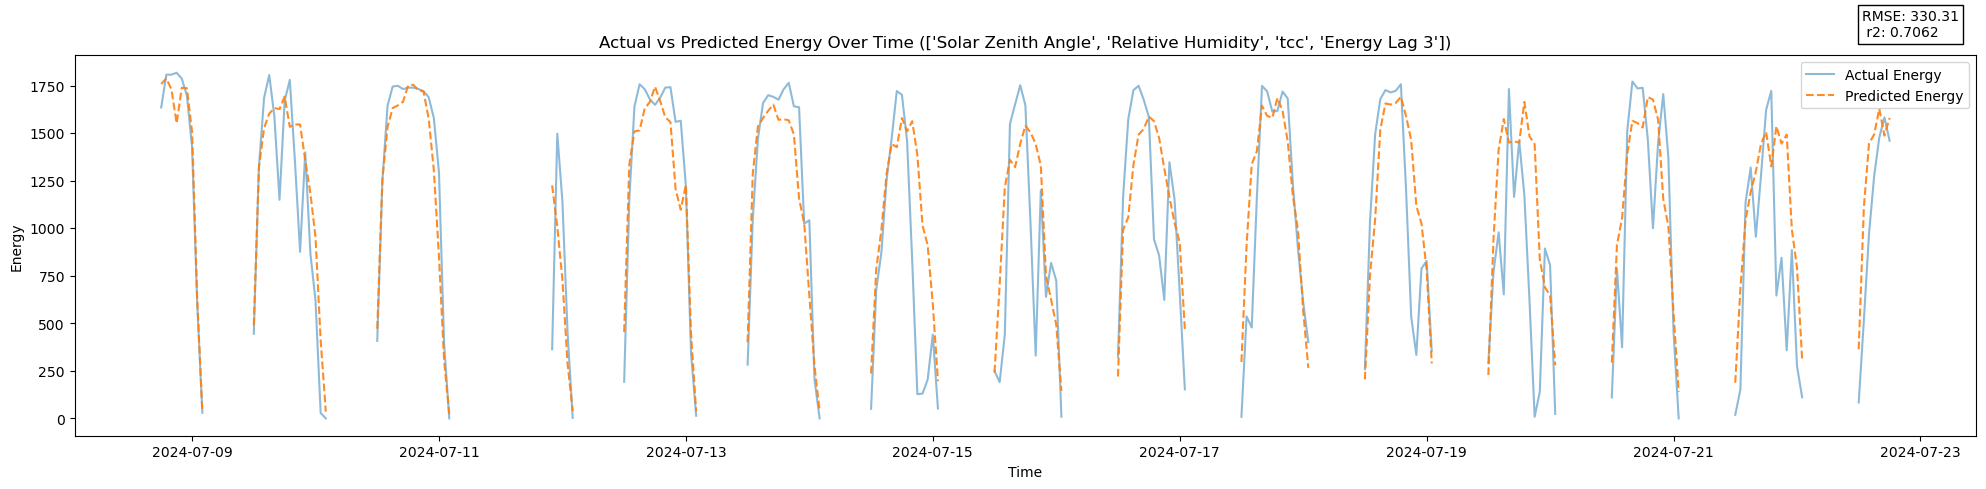

In [27]:
plot_data(features,ExtraTreeModels.predictions(features))

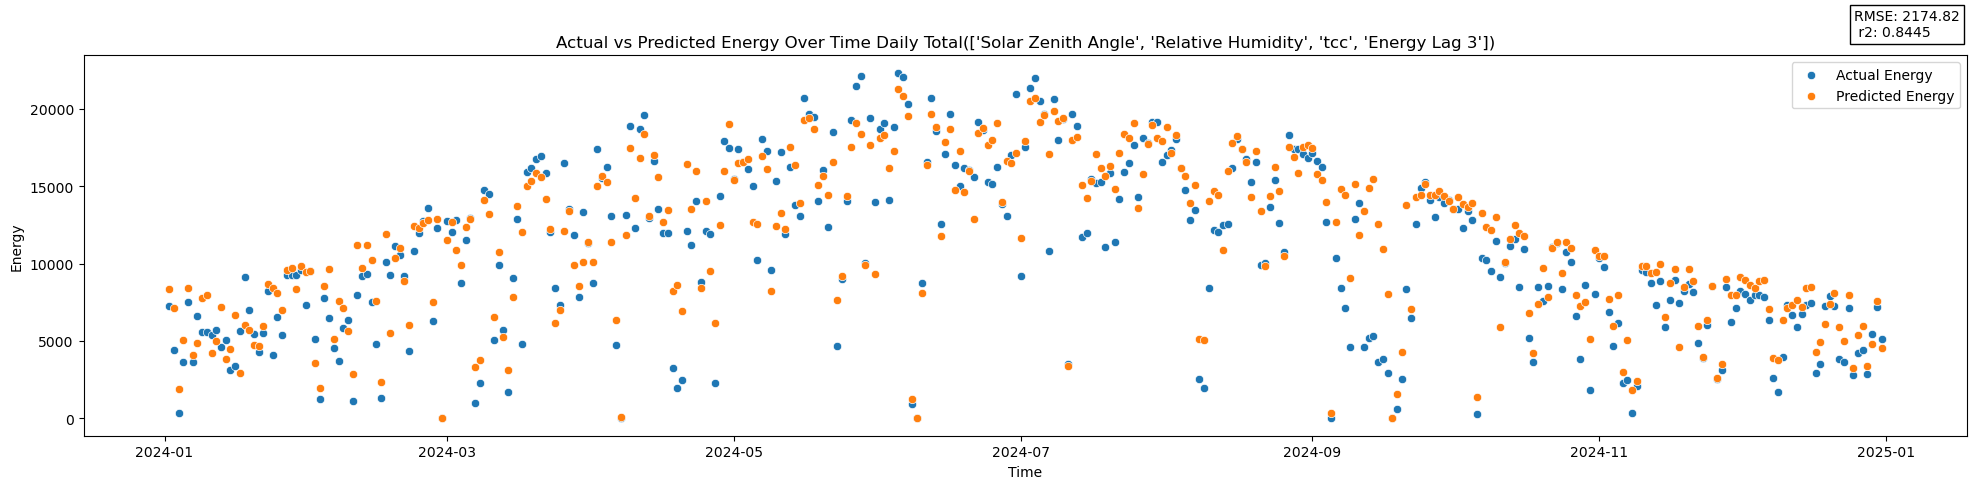

In [53]:
plot_daily_data(features,ExtraTreeModels.predictions(features))

In [28]:
XGBoostModels = XGBoostRegressions(SolarTrain,SolarTest)

In [29]:
features = ['Solar Zenith Angle','Relative Humidity','tcc']
XGBoostModels.fit(features)

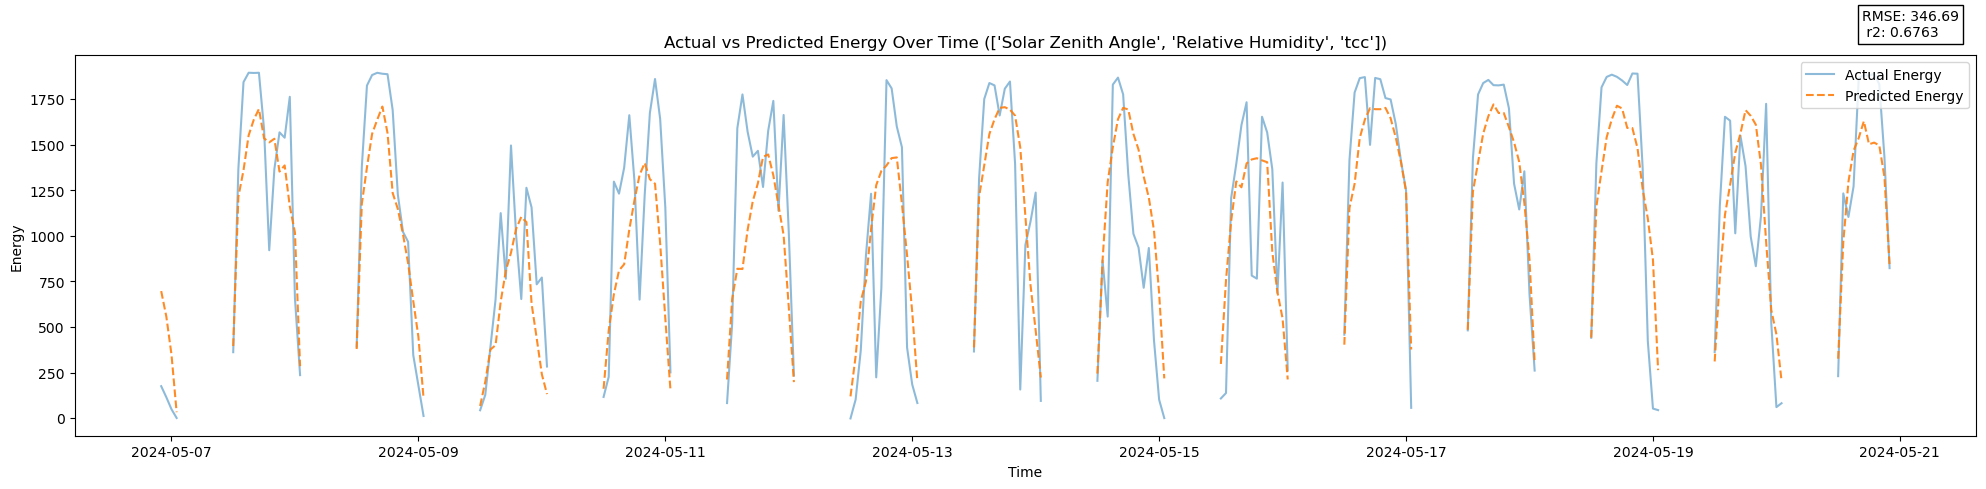

In [30]:
plot_data(features,XGBoostModels.predictions(features))

In [31]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Ambient Temperature']
XGBoostModels.fit(features)

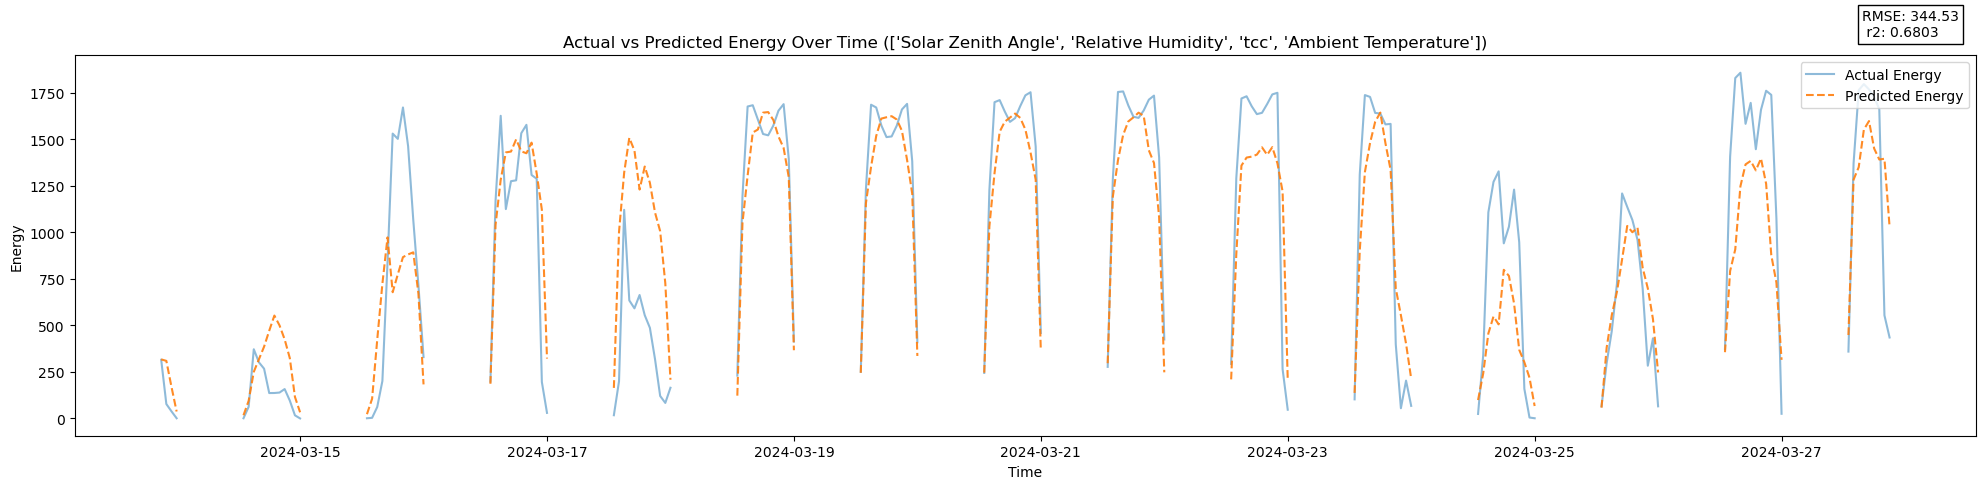

In [32]:
plot_data(features,XGBoostModels.predictions(features))

In [33]:
features = ['Solar Zenith Angle','Relative Humidity','tcc','Energy Lag 24']
XGBoostModels.fit(features)

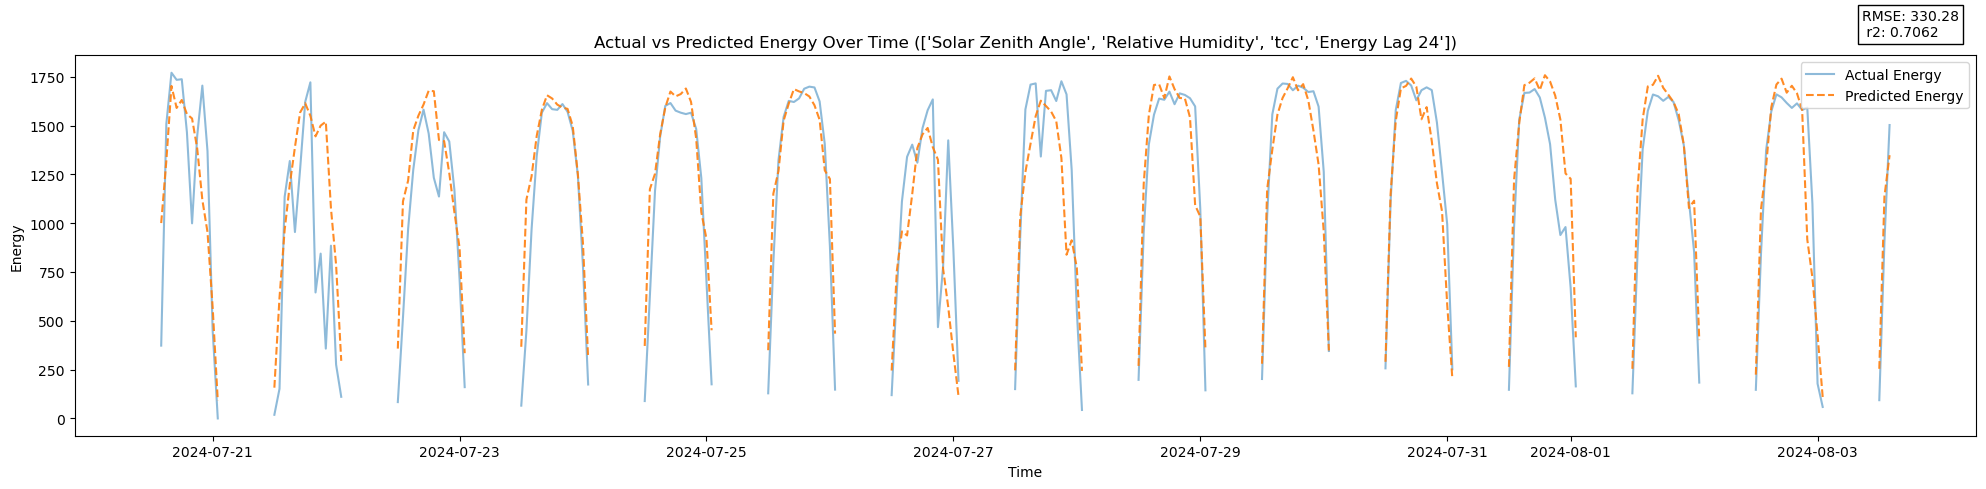

In [34]:
plot_data(features,XGBoostModels.predictions(features))

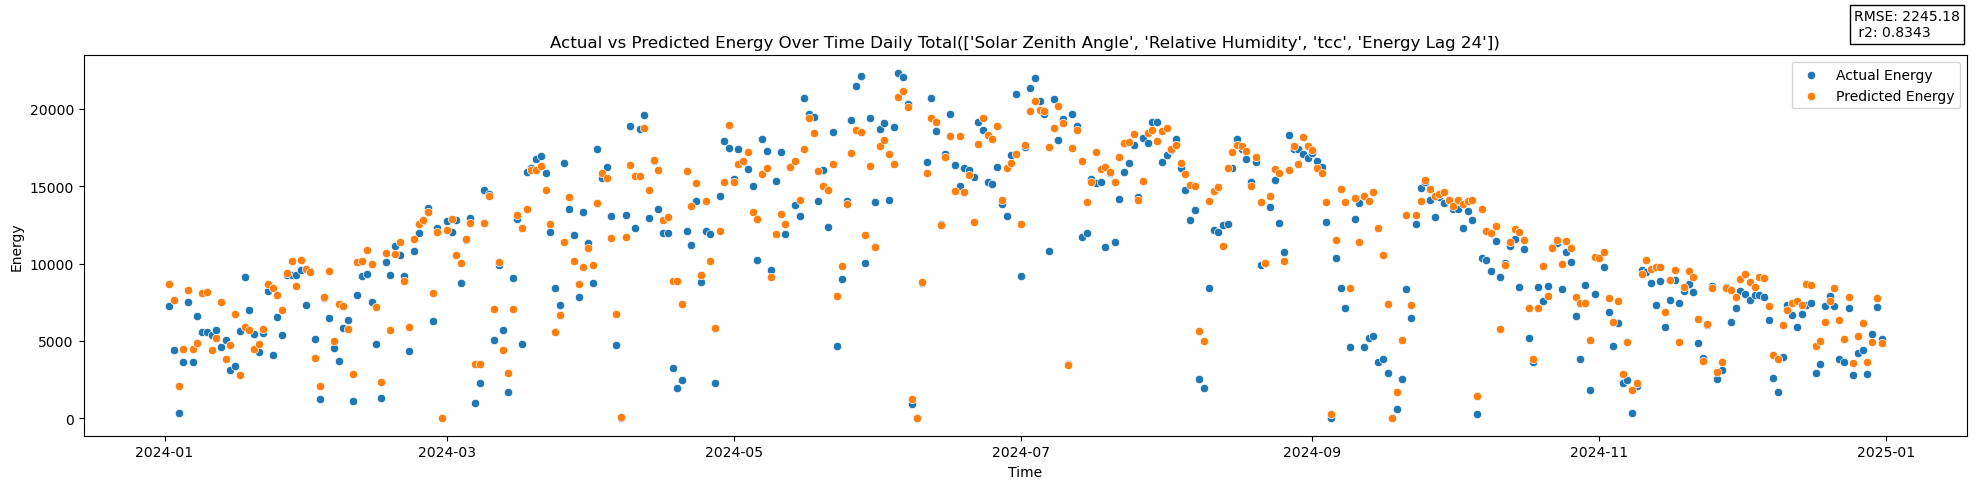

In [49]:
plot_daily_data(features,XGBoostModels.predictions(features))